In [495]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

Set random seed for reproducibility


In [496]:
torch.manual_seed(42)
np.random.seed(42)

Device configuration


In [497]:
device = "mps"
print(f"Using device: {device}")

Using device: mps


Load and prepare data


In [498]:
data = pd.read_csv("./data/rnn_full_data.csv")
data

,Year,Month,District,Location Group,holiday_count,sin_month,cos_month,crime_count
0,2018,1,1.0,EDUCATIONAL,2.0,0.0,1.000000,28.0
1,2018,1,1.0,FINANCIAL,2.0,0.0,1.000000,23.0
2,2018,1,1.0,FOOD_ENTERTAINMENT,2.0,0.0,1.000000,189.0
3,2018,1,1.0,GOVERNMENT,2.0,0.0,1.000000,16.0
4,2018,1,1.0,OFFICE_BUSINESS,2.0,0.0,1.000000,28.0
...,...,...,...,...,...,...,...,...
20220,2024,12,25.0,STREET_OUTDOOR,1.0,-0.5,0.866025,311.0
20221,2024,12,25.0,TRANSPORTATION,1.0,-0.5,0.866025,26.0
20222,2024,12,31.0,OTHER,1.0,-0.5,0.866025,1.0
20223,2024,12,31.0,RETAIL,1.0,-0.5,0.866025,1.0


Create a unique location identifier and time key


In [499]:
data["District"].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 14.,
       15., 16., 17., 18., 19., 20., 22., 24., 25., 31.])

In [500]:
data["time_key"] = data["Year"] * 12 + data["Month"]
data["location_key"] = data["Location Group"] + "_" + data["District"].astype(str)
data

,Year,Month,District,Location Group,holiday_count,sin_month,cos_month,crime_count,time_key,location_key
0,2018,1,1.0,EDUCATIONAL,2.0,0.0,1.000000,28.0,24217,EDUCATIONAL_1.0
1,2018,1,1.0,FINANCIAL,2.0,0.0,1.000000,23.0,24217,FINANCIAL_1.0
2,2018,1,1.0,FOOD_ENTERTAINMENT,2.0,0.0,1.000000,189.0,24217,FOOD_ENTERTAINMENT_1.0
3,2018,1,1.0,GOVERNMENT,2.0,0.0,1.000000,16.0,24217,GOVERNMENT_1.0
4,2018,1,1.0,OFFICE_BUSINESS,2.0,0.0,1.000000,28.0,24217,OFFICE_BUSINESS_1.0
...,...,...,...,...,...,...,...,...,...,...
20220,2024,12,25.0,STREET_OUTDOOR,1.0,-0.5,0.866025,311.0,24300,STREET_OUTDOOR_25.0
20221,2024,12,25.0,TRANSPORTATION,1.0,-0.5,0.866025,26.0,24300,TRANSPORTATION_25.0
20222,2024,12,31.0,OTHER,1.0,-0.5,0.866025,1.0,24300,OTHER_31.0
20223,2024,12,31.0,RETAIL,1.0,-0.5,0.866025,1.0,24300,RETAIL_31.0


Get unique locations and time points


In [501]:
locations = data["location_key"].unique()
locations.sort()
cat_size = len(locations)
time_points = sorted(data["time_key"].unique())
n_time = len(time_points)
location_map = {location: i for i, location in enumerate(locations)}
time_map = {time_point: i for i, time_point in enumerate(time_points)}
data["location_id"] = data["location_key"].map(location_map)
data["time_id"] = data["time_key"].map(time_map)
print(location_map)
print(time_map)

{'EDUCATIONAL_1.0': 0, 'EDUCATIONAL_10.0': 1, 'EDUCATIONAL_11.0': 2, 'EDUCATIONAL_12.0': 3, 'EDUCATIONAL_14.0': 4, 'EDUCATIONAL_15.0': 5, 'EDUCATIONAL_16.0': 6, 'EDUCATIONAL_17.0': 7, 'EDUCATIONAL_18.0': 8, 'EDUCATIONAL_19.0': 9, 'EDUCATIONAL_2.0': 10, 'EDUCATIONAL_20.0': 11, 'EDUCATIONAL_22.0': 12, 'EDUCATIONAL_24.0': 13, 'EDUCATIONAL_25.0': 14, 'EDUCATIONAL_3.0': 15, 'EDUCATIONAL_4.0': 16, 'EDUCATIONAL_5.0': 17, 'EDUCATIONAL_6.0': 18, 'EDUCATIONAL_7.0': 19, 'EDUCATIONAL_8.0': 20, 'EDUCATIONAL_9.0': 21, 'FINANCIAL_1.0': 22, 'FINANCIAL_10.0': 23, 'FINANCIAL_11.0': 24, 'FINANCIAL_12.0': 25, 'FINANCIAL_14.0': 26, 'FINANCIAL_15.0': 27, 'FINANCIAL_16.0': 28, 'FINANCIAL_17.0': 29, 'FINANCIAL_18.0': 30, 'FINANCIAL_19.0': 31, 'FINANCIAL_2.0': 32, 'FINANCIAL_20.0': 33, 'FINANCIAL_22.0': 34, 'FINANCIAL_24.0': 35, 'FINANCIAL_25.0': 36, 'FINANCIAL_3.0': 37, 'FINANCIAL_31.0': 38, 'FINANCIAL_4.0': 39, 'FINANCIAL_5.0': 40, 'FINANCIAL_6.0': 41, 'FINANCIAL_7.0': 42, 'FINANCIAL_8.0': 43, 'FINANCIAL_9.0

In [502]:
print(f"Number of unique locations: {len(locations)}")
print(f"Number of time points: {len(time_points)}")
data.describe()

Number of unique locations: 251
Number of time points: 84


,Year,Month,District,holiday_count,sin_month,cos_month,crime_count,time_key,location_id,time_id
count,20225.000000,20225.000000,20225.000000,20225.000000,20225.000000,2.022500e+04,20225.000000,20225.000000,20225.000000,20225.000000
mean,2021.000692,6.500025,12.239802,0.881088,-0.000303,3.805267e-04,83.412410,24258.508331,124.929197,41.508331
std,2.002767,3.453095,7.219549,0.661999,0.707080,7.071679e-01,131.593961,24.279982,72.342657,24.279982
min,2018.000000,1.000000,1.000000,0.000000,-1.000000,-1.000000e+00,1.000000,24217.000000,0.000000,0.000000
25%,2019.000000,3.000000,6.000000,0.000000,-0.866025,-5.000000e-01,11.000000,24237.000000,62.000000,20.000000
50%,2021.000000,7.000000,12.000000,1.000000,0.000000,6.123234e-17,25.000000,24259.000000,125.000000,42.000000
75%,2023.000000,10.000000,18.000000,1.000000,0.500000,8.660254e-01,69.000000,24280.000000,187.000000,63.000000
max,2024.000000,12.000000,31.000000,2.000000,1.000000,1.000000e+00,989.000000,24300.000000,250.000000,83.000000


In [503]:
cat_features = ["location_id"]
num_features = ["crime_count", "holiday_count", "Year", "sin_month", "cos_month"]

In [504]:
cat_matrix = np.zeros((len(time_points), len(locations), len(cat_features)))
num_matrix = np.zeros((len(time_points), len(locations), len(num_features)))

In [505]:
for _, row in data.iterrows():
    location_id = round(row["location_id"])
    time_id = round(row["time_id"])
    cat_matrix[time_id, location_id] = row[cat_features]
    num_matrix[time_id, location_id] = row[num_features]
cat_matrix.shape, num_matrix.shape

((84, 251, 1), (84, 251, 5))

In [506]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_scaled = num_matrix.copy()
for i in range(1, num_scaled.shape[2]):
    num_scaled[:, :, i] = scaler.fit_transform(num_matrix[:, :, i])
# n_locations = num_matrix.shape[1]
# scalers = {}
# for loc in range(n_locations):
#     scaler = MinMaxScaler()
#     crime_values = num_matrix[:, loc, 0].reshape(-1, 1)  # assuming index 0 is crime_count
#     num_scaled[:, loc, 0] = scaler.fit_transform(crime_values).flatten()
#     scalers[loc] = scaler  # Save the scaler for inverse transform later

In [507]:
seq_length = 12

In [508]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        target = data[i + seq_length, :, 0]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

Create sequences


In [509]:
X_cat, _ = create_sequences(cat_matrix, seq_length)
X_num, y = create_sequences(num_scaled, seq_length)
print(X_cat.shape)
print(X_num.shape)
print(y.shape)

(72, 12, 251, 1)
(72, 12, 251, 5)
(72, 251)


In [510]:
print(f"Number of sequences: {len(X_cat)}")
print(
    f"Categorical Input shape: {X_cat.shape}"
)  # [n_sequences, seq_length, n_locations, n_features]
print(
    f"Numerical Input shape: {X_num.shape}"
)  # [n_sequences, seq_length, n_locations, n_features]
print(f"Target shape: {y.shape}")  # [n_sequences, n_locations]

Number of sequences: 72
Categorical Input shape: (72, 12, 251, 1)
Numerical Input shape: (72, 12, 251, 5)
Target shape: (72, 251)


In [511]:
train_size = int(0.75 * len(X_cat))
X_train, X_val = (X_cat[:train_size], X_num[:train_size]), (
    X_cat[train_size:],
    X_num[train_size:],
)
y_train, y_val = y[:train_size], y[train_size:]

In [512]:
print(f"Training sequences: {len(X_train[0])}")
print(f"Validation sequences: {len(X_val[0])}")

Training sequences: 54
Validation sequences: 18


Convert to PyTorch tensors


In [513]:
X_train = (
    torch.tensor(X_train[0], dtype=torch.float32).to(device),
    torch.tensor(X_train[1], dtype=torch.float32).to(device),
)
X_val = (
    torch.tensor(X_val[0], dtype=torch.float32).to(device),
    torch.tensor(X_val[1], dtype=torch.float32).to(device),
)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
print(X_train[0].shape, X_train[1].shape, y_train.shape)
print(X_val[0].shape, X_val[1].shape, y_val.shape)

torch.Size([54, 12, 251, 1]) torch.Size([54, 12, 251, 5]) torch.Size([54, 251])
torch.Size([18, 12, 251, 1]) torch.Size([18, 12, 251, 5]) torch.Size([18, 251])


Define the RNN model


In [514]:
num_size = len(num_features)
cat_size = X_cat.shape[2]
hidden_size = 64
batch_size = 64
num_layers = 2
embed_dim = 16
output_size = 1
num_epochs = 50
dropout = 0.3

In [515]:
class CrimeLSTM(nn.Module):
    def __init__(
        self,
        num_size,
        cat_size,
        hidden_size,
        embed_dim,
        num_layers,
        output_size,
        dropout,
    ):
        super(CrimeLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(cat_size, embed_dim)
        self.lstm = nn.LSTM(
            input_size=num_size + embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        self.fc1 = nn.Linear(hidden_size, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x, h_0, c_0):
        # x: [seq_length, batch_size, n_features (crime_count, location_id)]

        # location_embed: [seq_length, batch_size, embed_dim]
        embed = self.embedding(x[0].squeeze(-1).long())
        # crime: [seq_length, batch_size, 1]
        crime_count = x[1][:, :, 0].unsqueeze(-1)
        num = x[1][:, :, 1:]
        # Combine crime and location embeddings
        x = torch.cat((embed, crime_count, num), dim=-1)
        # x: [seq_length, batch_size, embed_dim + 1]
        output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        output = self.fc1(output[-1])
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)

        return output, (h_n, c_n)

In [516]:
print(X_train[0].shape, X_train[1].shape)
model = CrimeLSTM(
    num_size, cat_size, hidden_size, embed_dim, num_layers, output_size, dropout
).to(device)
print(model)

torch.Size([54, 12, 251, 1]) torch.Size([54, 12, 251, 5])
CrimeLSTM(
  (embedding): Embedding(251, 16)
  (lstm): LSTM(21, 64, num_layers=2)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


Define loss function and optimizer


In [517]:
criterion = nn.MSELoss()

Training function


In [518]:
# Validation
def evaluate_model(model, X, y):
    model.eval()
    val_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in range(0, cat_size, batch_size):
            actual_batch_size = min(cat_size - batch, batch_size)
            h = torch.zeros(num_layers, actual_batch_size, hidden_size).to(device)
            c = torch.zeros(num_layers, actual_batch_size, hidden_size).to(device)
            for i in range(len(X[0])):
                cat_seq = X[0][i, :, batch : batch + actual_batch_size]
                num_seq = X[1][i, :, batch : batch + actual_batch_size]
                X_seq = (cat_seq, num_seq)
                target = y_train[i, batch : batch + actual_batch_size]
                h, c = h.detach(), c.detach()
                score, (h, c) = model(X_seq, h, c)
                loss = criterion(score, target.unsqueeze(1))
                val_loss += loss.item()
                num_batches += 1
    total_val_loss = val_loss / num_batches
    return total_val_loss

In [519]:
start_time = time.time()
train_losses = []
val_losses = []
my_lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=my_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=4, factor=0.5
)
n_seq = len(X_train[0])
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    num_batches = 0
    for batch in range(0, cat_size, batch_size):
        actual_batch_size = min(cat_size - batch, batch_size)
        h = torch.zeros(num_layers, actual_batch_size, hidden_size).to(device)
        c = torch.zeros(num_layers, actual_batch_size, hidden_size).to(device)
        for i in range(n_seq):
            optimizer.zero_grad()
            cat_seq = X_train[0][i, :, batch : batch + actual_batch_size]
            num_seq = X_train[1][i, :, batch : batch + actual_batch_size]
            X_seq = (cat_seq, num_seq)
            target = y_train[i, batch : batch + actual_batch_size]
            h, c = h.detach(), c.detach()
            score, (h, c) = model(X_seq, h, c)
            loss = criterion(score, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            num_batches += 1
    train_loss /= num_batches
    train_losses.append(train_loss)
    val_loss = evaluate_model(model, X_val, y_val)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.12f}, Val Loss: {val_loss:.12f}, learning rate: {scheduler.get_last_lr()[0]:.12f}, time: {time.time() - start_time:.2f} seconds"
    )

Epoch [1/50], Train Loss: 11828.961647863742, Val Loss: 7236.822890811496, learning rate: 0.001000000000, time: 1.73 seconds
Epoch [2/50], Train Loss: 3942.515932069884, Val Loss: 4046.229893260532, learning rate: 0.001000000000, time: 3.19 seconds
Epoch [3/50], Train Loss: 2116.177935644432, Val Loss: 3272.337873193953, learning rate: 0.001000000000, time: 4.70 seconds
Epoch [4/50], Train Loss: 1766.543074806531, Val Loss: 2894.621325704787, learning rate: 0.001000000000, time: 6.16 seconds
Epoch [5/50], Train Loss: 1356.466147678870, Val Loss: 3310.294337696499, learning rate: 0.001000000000, time: 7.80 seconds
Epoch [6/50], Train Loss: 1118.376922616252, Val Loss: 3573.279180314806, learning rate: 0.001000000000, time: 9.75 seconds
Epoch [7/50], Train Loss: 1047.145728923656, Val Loss: 4008.396685600281, learning rate: 0.001000000000, time: 11.55 seconds
Epoch [8/50], Train Loss: 924.597601577088, Val Loss: 3827.025987201267, learning rate: 0.001000000000, time: 13.32 seconds
Epoch 

Train the model


Plot training and validation loss


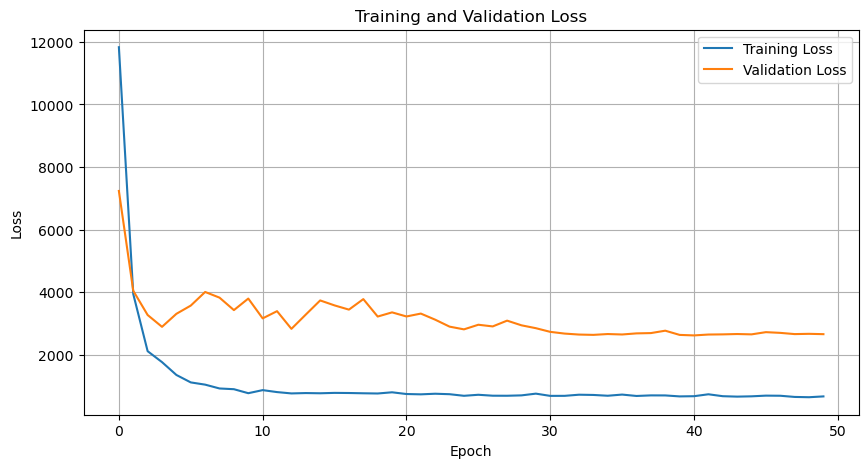

In [520]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("./figure/training_validation_loss.pdf", format="pdf")
plt.show()

In [521]:
def predictions(model, X, y):
    num_seq, _, n_location, n_features = X[0].shape
    result = np.zeros((num_seq, n_location, 2))
    with torch.no_grad():
        for batch in range(0, n_location, batch_size):
            actual_batch_size = min(cat_size - batch, batch_size)
            h = torch.zeros(num_layers, actual_batch_size, hidden_size).to(device)
            c = torch.zeros(num_layers, actual_batch_size, hidden_size).to(device)
            for i in range(len(X[0])):
                cat_seq = X[0][i, :, batch : batch + actual_batch_size]
                num_seq = X[1][i, :, batch : batch + actual_batch_size]
                seq = (cat_seq, num_seq)
                target = y[i, batch : batch + actual_batch_size]
                score, (h, c) = model(seq, h, c)
                result[i, batch : batch + actual_batch_size, 0] = (
                    score.cpu().numpy().flatten()
                )
                result[i, batch : batch + actual_batch_size, 1] = (
                    target.cpu().numpy().flatten()
                )
    return result

In [522]:
prediction_model = model.to("mps")
result = predictions(model, X_val, y_val)

# predicted_scaled = scaled_result[:, :, 0]
# actual_scaled = scaled_result[:, :, 1]
# print(predicted_scaled.shape)
# predicted_unscaled = np.zeros_like(predicted_scaled)
# actual_unscaled = np.zeros_like(actual_scaled)

# for loc in range(n_locations):
#     scaler = scalers[loc]
#     # Reshape (18,) -> (18, 1) for inverse_transform
#     predicted_unscaled[:, loc] = scaler.inverse_transform(predicted_scaled[:, loc].reshape(-1, 1)).flatten()
#     actual_unscaled[:, loc] = scaler.inverse_transform(actual_scaled[:, loc].reshape(-1, 1)).flatten()
# result = np.zeros((len(predicted_scaled), len(locations), 2))
# result[:, :, 0] = predicted_unscaled
# result[:, :, 1] = actual_unscaled
result[:, :, 0] = np.round(result[:, :, 0])

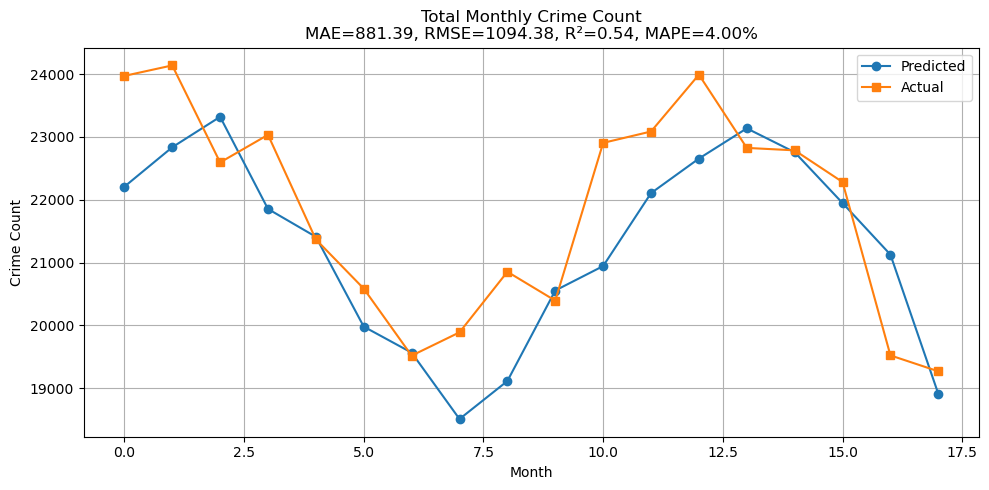

In [523]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Assuming `result` is already defined: shape (18, 251, 2)
predicted = result[..., 0]  # shape (18, 251)
actual = result[..., 1]  # shape (18, 251)

# Sum over all 251 locations for each of the 18 months
monthly_predicted = predicted.sum(axis=1)
monthly_actual = actual.sum(axis=1)

# Evaluation metrics for total monthly prediction
mae = mean_absolute_error(monthly_actual, monthly_predicted)
rmse = root_mean_squared_error(monthly_actual, monthly_predicted)
r2 = r2_score(monthly_actual, monthly_predicted)
mape = (
    np.mean(np.abs((monthly_actual - monthly_predicted) / (monthly_actual + 1e-8)))
    * 100
)

# Plotting total predicted vs actual
plt.figure(figsize=(10, 5))
plt.plot(monthly_predicted, label="Predicted", marker="o")
plt.plot(monthly_actual, label="Actual", marker="s")
plt.title(
    f"Total Monthly Crime Count\nMAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.2f}, MAPE={mape:.2f}%"
)
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./figure/total_monthly_crime_count_lstm.pdf", format="pdf")
plt.show()

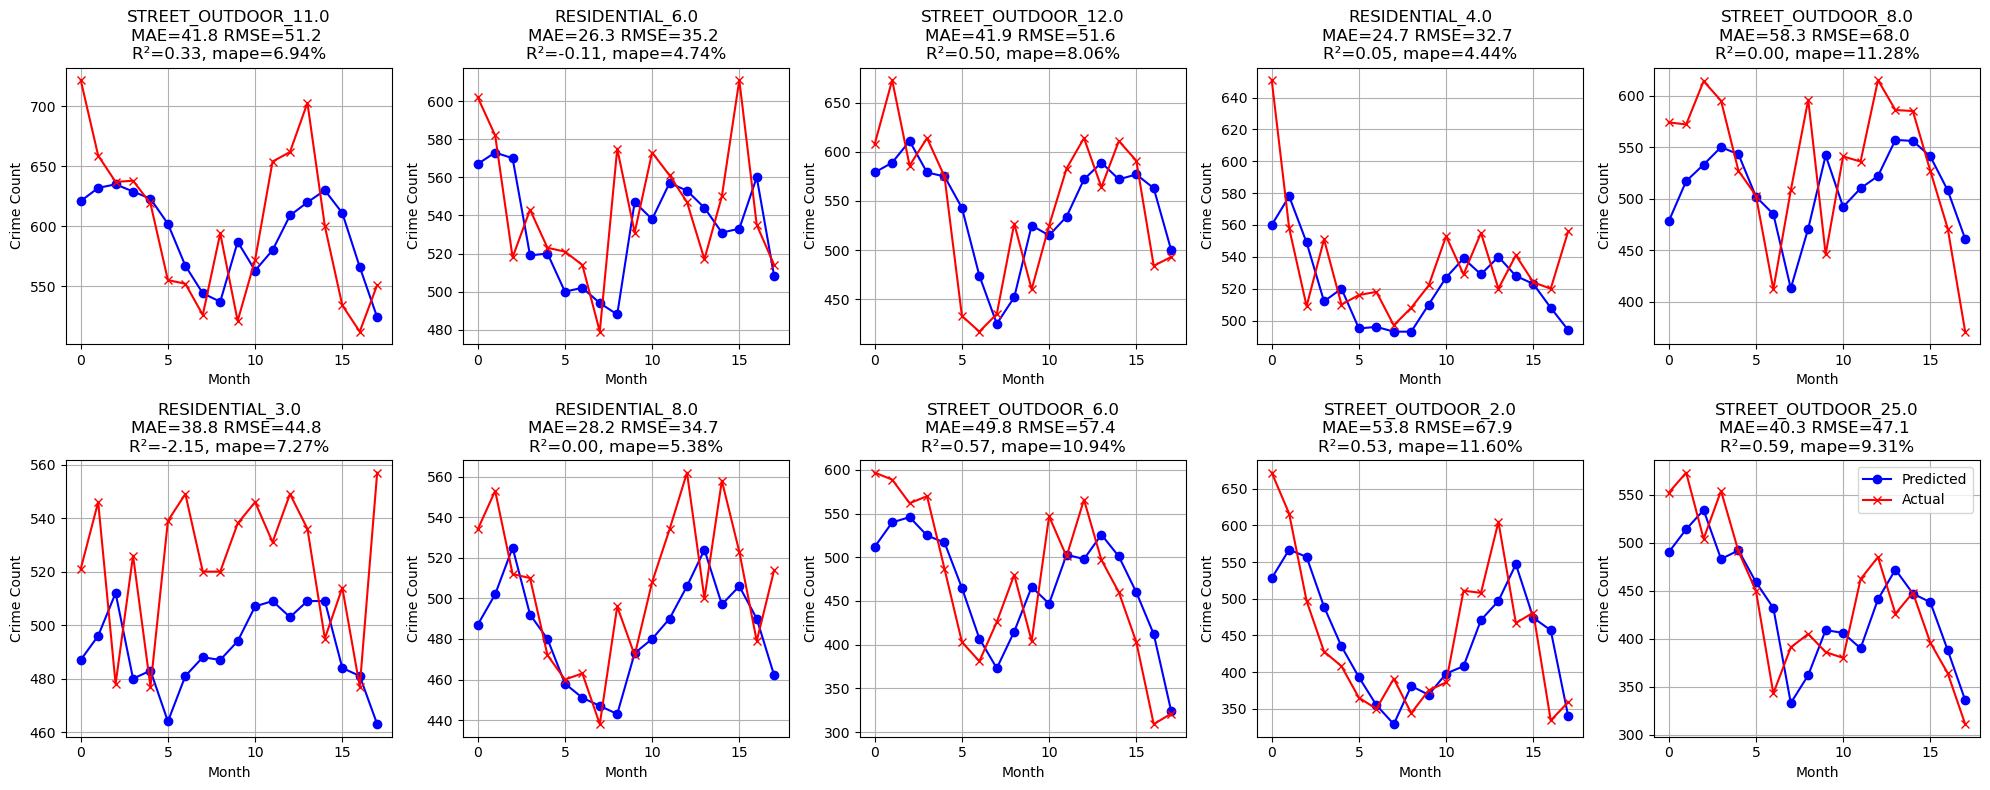

In [ ]:
inverse_location_map = {v: k for k, v in location_map.items()}
mean_crime_per_location = actual.mean(axis=0)
top_indices = np.argsort(-mean_crime_per_location)[:10]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, loc_idx in enumerate(top_indices):
    y_true = actual[:, loc_idx]
    y_pred = predicted[:, loc_idx]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

    axes[idx].plot(y_pred, label="Predicted", marker="o", color="blue")
    axes[idx].plot(y_true, label="Actual", marker="x", color="red")
    axes[idx].set_title(
        f"{inverse_location_map[loc_idx]}\nMAE={mae:.1f} RMSE={rmse:.1f} \nR²={r2:.2f}, mape={mape:.2f}%"
    )
    axes[idx].set_xlabel("Month")
    axes[idx].set_ylabel("Crime Count")
    axes[idx].grid(True)

plt.tight_layout()
plt.legend(loc="upper right")
plt.savefig("./figure/top_10_locations_lstm.pdf", format="pdf")
plt.show()

In [525]:
def evaluate_all_locations(predicted, actual, min_actual_for_mape=10):
    n_locations = actual.shape[1]
    maes, rmses, r2s, mapes = [], [], [], []

    for loc_idx in range(n_locations):
        y_true = actual[:, loc_idx]
        y_pred = predicted[:, loc_idx]

        maes.append(mean_absolute_error(y_true, y_pred))
        rmses.append(root_mean_squared_error(y_true, y_pred))
        r2s.append(r2_score(y_true, y_pred))

        # Filtered MAPE for better stability
        mask = np.abs(y_true) >= min_actual_for_mape
        if mask.sum() > 0:
            mape = (
                np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + 1e-8)))
                * 100
            )
        else:
            mape = np.nan  # no valid points
        mapes.append(mape)

    print("📊 Evaluation Metrics Averaged Over All Locations:")
    print(f"▶ Mean MAE       : {np.nanmean(maes):.2f}")
    print(f"▶ Mean RMSE      : {np.nanmean(rmses):.2f}")
    print(f"▶ Mean R²        : {np.nanmean(r2s):.4f}")
    print(
        f"▶ Mean MAPE (%)  : {np.nanmean(mapes):.2f}% (filtered actual < {min_actual_for_mape})"
    )

In [526]:
evaluate_all_locations(predicted, actual)

📊 Evaluation Metrics Averaged Over All Locations:
▶ Mean MAE       : 9.89
▶ Mean RMSE      : 12.33
▶ Mean R²        : -0.1494
▶ Mean MAPE (%)  : 20.36% (filtered actual < 10)


In [527]:
month_result = np.sum(result, axis=1)
month_result

array([[22207., 23971.],
       [22835., 24138.],
       [23320., 22594.],
       [21853., 23033.],
       [21410., 21368.],
       [19980., 20585.],
       [19566., 19518.],
       [18509., 19889.],
       [19114., 20853.],
       [20555., 20394.],
       [20944., 22905.],
       [22105., 23086.],
       [22655., 23991.],
       [23136., 22825.],
       [22756., 22786.],
       [21947., 22282.],
       [21126., 19522.],
       [18910., 19269.]])